In [18]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [19]:
def pole_correct_UV(dax, day, x="longitude", y="latitude"):
    """
    Correct U and V data so that it will plot nicely at the pole

    Parameters
    ----------
    dax, day : xarray.DataArray
        DataArrays for the x and y component of the vector arrow
    x : str, default 'longitude'
        Longitude coordinate name
    y : str, default 'latitude'
        Latitude coordinate name

    Returns
    -------
    bu,bv : corrected U and V components
    """

    lats, lons = dax[y].values, dax[x].values
    lon2d, lat2d = np.meshgrid(lons, lats)

    X, Y = dax.values, day.values

    X_src_crs = X / np.cos(lat2d / 180 * np.pi)
    Y_src_crs = Y
    magnitude = np.sqrt(X**2 + Y**2)
    magn_src_crs = np.sqrt(X_src_crs**2 + Y_src_crs**2)

    bu = X_src_crs * magnitude / magn_src_crs
    bv = Y_src_crs * magnitude / magn_src_crs

    return bu, bv, lon2d, lat2d

In [20]:
def saddle_mask_from_uv(
    U, V, x=None, y=None, dx=None, dy=None, det_tol=0.0, edge_order=2, return_eigs=False):
    """
    Identify saddle points in a 2D velocity field using the velocity-gradient eigenvalue criterion.

    For a 2D Jacobian J = [[Ux, Uy], [Vx, Vy]], a saddle (real eigenvalues, opposite signs)
    is equivalent to det(J) < 0.

    Parameters
    ----------
    U, V : 2D ndarray, shape (ny, nx)
        Velocity components on a 2D grid.
        Convention assumed: axis-0 is y (rows), axis-1 is x (cols).
    x, y : 1D ndarray, optional
        Grid coordinates. If provided, should be:
          x.shape == (nx,), y.shape == (ny,)
        Units can be meters, km, etc., but must be consistent.
    dx, dy : float, optional
        Grid spacing in x and y if x,y are not provided (regular grid).
    det_tol : float, optional
        Tolerance for determinant negativity. Saddle if det < -det_tol.
        Use e.g. det_tol=1e-12 to avoid noise-triggered saddles.
    edge_order : {1, 2}, optional
        Accuracy order for np.gradient at boundaries.
    return_eigs : bool, optional
        If True, also return eigenvalues (lambda1, lambda2) and discriminant.

    Returns
    -------
    mask : 2D bool ndarray
        True where saddle criterion met.
    detJ : 2D ndarray
        Determinant of Jacobian (Ux*Vy - Uy*Vx).
    out : dict (only if return_eigs=True)
        Contains lambda1, lambda2, trace, discriminant.
    """
    U = np.asarray(U, dtype=float)
    V = np.asarray(V, dtype=float)
    if U.shape != V.shape or U.ndim != 2:
        raise ValueError(
            f"U and V must be 2D arrays with same shape; got {U.shape} and {V.shape}"
        )

    ny, nx = U.shape

    # Determine spacings for gradient
    if x is not None or y is not None:
        if x is None or y is None:
            raise ValueError("Provide both x and y, or neither.")
        x = np.asarray(x, dtype=float)
        y = np.asarray(y, dtype=float)
        if x.shape != (nx,) or y.shape != (ny,):
            raise ValueError(
                f"x must be (nx,), y must be (ny,). Got {x.shape}, {y.shape}"
            )
        # np.gradient returns derivatives in axis order: (d/dy, d/dx)
        Uy, Ux = np.gradient(U, y, x, edge_order=edge_order)
        Vy, Vx = np.gradient(V, y, x, edge_order=edge_order)
    else:
        if dx is None or dy is None:
            raise ValueError("Provide either (x,y) coordinates or (dx,dy) spacings.")
        Uy, Ux = np.gradient(U, dy, dx, edge_order=edge_order)
        Vy, Vx = np.gradient(V, dy, dx, edge_order=edge_order)

    detJ = Ux * Vy - Uy * Vx
    mask = detJ < -float(det_tol)

    if not return_eigs:
        return mask, detJ

    # Optional: eigenvalues of 2x2 Jacobian via closed form
    tr = Ux + Vy
    disc = tr**2 - 4.0 * detJ  # discriminant
    # numerical guard:
    disc_clip = np.maximum(disc, 0.0)
    s = np.sqrt(disc_clip)
    lam1 = 0.5 * (tr + s)
    lam2 = 0.5 * (tr - s)

    return (
        mask,
        detJ,
        {"lambda1": lam1, "lambda2": lam2, "trace": tr, "discriminant": disc},
    )

In [21]:
def add_streamline_plot_to_ax(dax, day, axs, x="longitude", y="latitude", **figkwargs):
    """
    Add a streamlines plot to a pre-existing set of axes

    Parameters
    ----------
    dax, day : xarray.DataArray
        DataArrays for the x and y component of the vector arrow
    axs : matplotlib.axes.Axes
    x : str, default 'longitude'
        Longitude coordinate name
    y : str, default 'latitude'
        Latitude coordinate name
    **figkwargs : optional
        An assortment of figkwargs. See the matplotlib.pyplot.streamplot documentation for details

    Returns
    -------
    p : matplotlib.pyplot.streamplot
    """



    lats, lons = dax[y].values, dax[x].values
    lon2d, lat2d = np.meshgrid(lons, lats)

    X, Y = dax.values, day.values

    X_src_crs = X / np.cos(lat2d / 180 * np.pi)
    Y_src_crs = Y
    magnitude = np.sqrt(X**2 + Y**2)
    magn_src_crs = np.sqrt(X_src_crs**2 + Y_src_crs**2)

    bu = X_src_crs * magnitude / magn_src_crs
    bv = Y_src_crs * magnitude / magn_src_crs

    lw = 25 * np.sqrt(bu**2 + bv**2)# / np.sqrt(bu**2 + bv**2).max()
    lw = np.nan_to_num(lw, nan=0.0)

    figkwargs = {
        "density": 4,
        "linewidth": lw,
        "arrowsize": 1,
        "color": magnitude,
        "cmap":'viridis',
        **figkwargs,
    }

    p = axs.streamplot(lon2d, lat2d, bu, bv, transform=ccrs.PlateCarree(), **figkwargs)

    cbar = plt.colorbar(p.lines, ax=ax, pad=0.05)
    cbar.set_label("Speed (m/s)")

    plt.title(f"Velocity Streamlines for year {year}")

    return p

In [28]:
ds = xr.open_dataset("cmems_mod_arc_phy_my_topaz4_P1M_vxo-vyo_180.00W-179.88E_50.00N-90.00N_0.00-4000.00m_1991-01-01-2025-08-01.nc")

year = "2007"

u = ds["vxo"].sel(time=year).isel(depth=0).mean("time").compute()  # zonal (east-west)
v = ds["vyo"].sel(time=year).isel(depth=0).mean("time").compute()

u,v,X,Y = pole_correct_UV(u,v)
x = X[0,:]
y = Y[:,0]

mask,detJ = saddle_mask_from_uv(u,v,x=x,y=y,det_tol=1e-2)


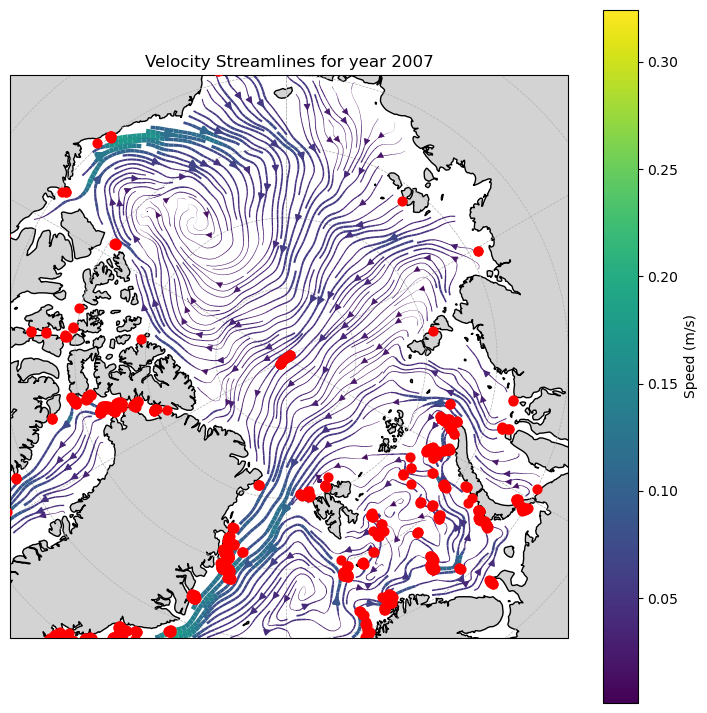

In [29]:
# -------------------------------------------------
# 5. Plot results
# -------------------------------------------------
proj_map = ccrs.NorthPolarStereo()
proj_data = ccrs.PlateCarree()  # because u/v are on lat-lon grid

fig = plt.figure(figsize=(9, 9))
ax = plt.axes(projection=proj_map)
#
# # Focus on Arctic (change for Antarctic)
ax.set_extent([-180, 180, 70, 90], crs=proj_data)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.coastlines(resolution='50m')
ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='--')
u = ds["vxo"].sel(time=year).isel(depth=0).mean("time").compute()  # zonal (east-west)
v = ds["vyo"].sel(time=year).isel(depth=0).mean("time").compute()

ax = add_streamline_plot_to_ax(u,v,ax)

# Saddles
jj, ii = np.where(mask)
plt.scatter(X[jj,ii], Y[jj,ii], c='red', s=40, label='Saddles', zorder=5,transform=proj_data)
